# EasyOCR을 이용한 필드 추출
https://github.com/JaidedAI/EasyOCR

- EasyOCR은 문자 영역 인식(Detection), 문자 인식(Recognition)을 손쉽게 수행 할 수 있도록 하는 Python 패키지이다.<br/>
- EasyOCR은 구현이 간단하고 매우 직관적이다. 현재 80개 이상의 언어를 지원하고 있으며, 꾸준히 Releases 되고 있다.(마지막 releases: 2024.08.24) <br/>
- 오픈소스 모델이다<br/>

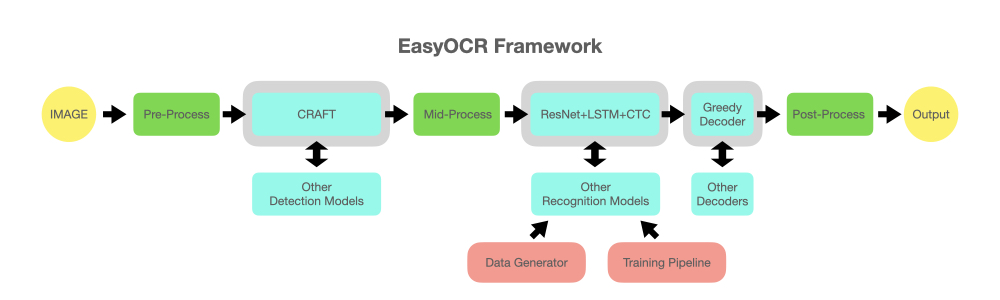

- EasyOCR은 OCR 오픈소스로 Text Detection은 CRAFT를 사용하고 Recognition은 CRNN을 사용한다.
- Framework는 모든 소스가 pytorch로 작성되어 있다.
- OCR 수행결과와 텍스트의 Bounding Box 좌표까지 얻을 수 있다.
- 위의 이미지에서 회색 테두리로 표시된 영역은 사용자들이 커스텀해서 사용할 수 있다. 사용자가 원하는 detection 모델, recognition 모델이 따로 있다면 해당 부분에 적용해 사용할 수 있다.

## CRAFT(Character Region Awareness for Text Detection)
- Naver의 Clova AI 팀에서 발표.
- 이미지 속 글자 하나하나의 위치를 정확히 찾아주는 기술, OCR 전 글자를 정확히 감지하는데 필요
- CRAFT 논문 리뷰 참고: https://medium.com/@msmapark2/character-region-awareness-for-text-detection-craft-paper-%EB%B6%84%EC%84%9D-da987b32609c

## CRNN(Convolutional Recurrent Neural Network)
- 중국에서 발표 (Baoguang Shi)
- CRNN = ResNet -> LSTM -> CTC
- 이미지의 특징 뽑기 -> 뽑은 특징을 순서대로 이해(전체 문맥 파악) -> 출력된 글자 예측 결과에서 불필요한 중복을 제거하고 최종적으로 정확한 텍스트를 뽑아줌
- CRNN 결론: 이미지 속에서 글자들을 순서대로 읽어 텍스트로 바꿔주는 기술
- CRAFT로 글자 위치를 파악해서 CRNN이 해당 위치의 글자를 읽어줌.
- CRNN 설명 참고: https://pnnote.tistory.com/entry/CRNN-%EB%AA%A8%EB%8D%B8-%EA%B0%9C%EC%9A%94-An-End-to-End-Trainable-Neural-Network-for-Image-based-SequenceRecognition-and-Its-Application-to-Scene-Text-Recognition

In [2]:
pip install easyocr

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
from PIL import Image
import cv2

# 한글 경로 문제 해결: PIL로 열고 OpenCV 이미지로 변환
def load_image_with_pil(image_path):
    pil_image = Image.open(image_path).convert("RGB")
    return cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

In [4]:
import easyocr

def run_ocr(image_path: str) -> str:
    # 한글 경로 해결된 이미지 전달
    reader = easyocr.Reader(['ko'], gpu=False)
    img_cv = load_image_with_pil(image_path)
    result = reader.readtext(img_cv, detail=0)
    return  "\n".join(result)

In [5]:
# === 2. 필드 정의 ===
target_fields = [
    "접수번호", "성명", "소속", "지위", "생년월일", "전화번호", "주소",
    "입사일자", "실 근속년 수", "신청금액", "자금용도", "대출기일",
    "상환예정일", "담보 여건", "신청날짜", "신청인"
]

In [8]:
from typing import Dict

# === 3. 필드 추출 함수 ===
def extract_fields(lines: str) -> Dict[str, str]:
    lines = lines.splitlines()
    extracted = {}

    for i, line in enumerate(lines):
        for field in target_fields:
            # 필드명이 현재 줄에 포함되어 있고 아직 추출 안 된 경우
            if field.replace(" ", "") in line.replace(" ", "") and field not in extracted:
                # 다음 줄이 존재하면 값으로 사용
                if i + 1 < len(lines):
                    value = lines[i + 1].strip()
                    extracted[field] = value
                else:
                    extracted[field] = ""
                break
        else:
            continue

    # 누락 필드 빈값 처리
    for field in target_fields:
        if field not in extracted:
            extracted[field] = ""
    return extracted

In [9]:
# 이미지 파일 경로 지정
image_path = "../documents/직원대출신청서_5개모음집_pages-to-jpg-0001.jpg"

# OCR 수행
ocr_result = run_ocr(image_path)
print("🧾 OCR 결과:")
print(ocr_result)


Using CPU. Note: This module is much faster with a GPU.
C:\Users\user\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🧾 OCR 결과:
담   당
직원
대출신청서
접수번호 *
20250401
성   명
김하늘
소속/직위
마켓팅팀 / 대리
인적
생년월일
1992
06 -15
전화번호
010 - 1234
5678
사항
주  소
서울특별시   강남구 테혜란로
123
입사일자
2018년 3월 | 일
실 근속년수
6년   [개월
신청금액
일금
삼백만
원정 (# 3,00,99
의료비
자금용도
대출기일
2025년어월이일
상환예정일
2026년65원이일
무담보
담보 (보종) 여건
상기   본인은  직원대출올 밭고자 신청합니다:
203년야원22일
위 신청인
김하늘
(인)
주식회사 00


In [10]:
# 필드 추출
fields = extract_fields(ocr_result)

In [11]:
print("\n📦 추출된 필드:")
for k, v in fields.items():
    print(f"{k}: {v}")


📦 추출된 필드:
접수번호: 20250401
성명: 김하늘
소속: 마켓팅팀 / 대리
생년월일: 1992
전화번호: 010 - 1234
주소: 서울특별시   강남구 테혜란로
입사일자: 2018년 3월 | 일
실 근속년 수: 6년   [개월
신청금액: 일금
자금용도: 대출기일
대출기일: 2025년어월이일
상환예정일: 2026년65원이일
신청인: 김하늘
지위: 
담보 여건: 
신청날짜: 


# EasyOCR 박스 시각화

## ✅ readertext detail 값 별 의미
```reader.readtext(image, detail=0)```

|값|의미|반환 타입|
|----|----|----|
|`detail=0`|텍스트만 반환|`['김하늘', '서울특별시', ...]`|
|`detail=1`|위치 + 텍스트 + 신뢰도 반환|`[[bbox, text, confg], ...]`|
|`detail=2`|각 단계 정보까지 포함된 딕셔너리|실험적 기능(잘 안씀)|

## ✅ bbox, text, conf 각각의 의미
```python
[
    [[[x1, y1], [x2, y2], [x3, y3], [x4, y4]], "김하늘", 0.99],
    ...
]
```
|항목|설명|
|----|----|
|`bbox`| 텍스트 영역의 네 꼭짓점 좌표(사각형: 왼쪽 위부터 시계방향) |
|`text`| OCR로 인식된 문자열 |
|`conf`| 신뢰도(confidence score, 0~1)|


In [12]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import easyocr
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image, ImageDraw, ImageFont
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [14]:
def visualize_ocr_boxes(image_path):
    reader = easyocr.Reader(['ko'], gpu=False)
    
    # 한글 경로 대응: 이미지 배열로 변환
    img_cv = load_image_with_pil(image_path)

    # EasyOCR에 이미지 직접 넘기기
    results = reader.readtext(img_cv, detail=1)
    
    for bbox, text, conf in results:
        print(f"{bbox} : {text}")
    
    # 이미지 복사 (시각화용 RGB)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    draw = ImageDraw.Draw(img_pil)

    # 한글 폰트 경로 설정 (Windows 기준: 맑은 고딕)
    font_path = "C:/Windows/Fonts/malgun.ttf"
    font = ImageFont.truetype(font_path, 18)
    
    for (bbox, text, confidence) in results:
        pts = [(int(x), int(y)) for x, y in bbox]
        draw.line(pts + [pts[0]], fill=(0, 255, 0), width=2)
        draw.text((pts[0][0], pts[0][1] - 20), text, font=font, fill=(255, 0, 0))
        
        cx = int((bbox[0][0] + bbox[2][0]) / 2)
        cy = int((bbox[0][1] + bbox[2][1]) / 2)
        draw.text((cx, cy), f"({cx},{cy})", font=font, fill=(0, 0, 255))

    img_pil.save("output_result.png")
    # 시각화
    plt.figure(figsize=(12, 12))
    plt.imshow(img_pil)
    plt.axis('off')
    plt.title("EasyOCR 인식 결과 박스 시각화")
    plt.show()


Using CPU. Note: This module is much faster with a GPU.
C:\Users\user\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[[np.int32(758), np.int32(146)], [np.int32(818), np.int32(146)], [np.int32(818), np.int32(172)], [np.int32(758), np.int32(172)]] : 담   당
[[np.int32(282), np.int32(172)], [np.int32(368), np.int32(172)], [np.int32(368), np.int32(226)], [np.int32(282), np.int32(226)]] : 직원
[[np.int32(384), np.int32(172)], [np.int32(594), np.int32(172)], [np.int32(594), np.int32(228)], [np.int32(384), np.int32(228)]] : 대출신청서
[[np.int32(194), np.int32(304)], [np.int32(298), np.int32(304)], [np.int32(298), np.int32(330)], [np.int32(194), np.int32(330)]] : 접수번호 *
[[np.int32(372), np.int32(306)], [np.int32(470), np.int32(306)], [np.int32(470), np.int32(332)], [np.int32(372), np.int32(332)]] : 20250401
[[np.int32(250), np.int32(348)], [np.int32(334), np.int32(348)], [np.int32(334), np.int32(378)], [np.int32(250), np.int32(378)]] : 성   명
[[np.int32(377), np.int32(349)], [np.int32(439), np.int32(349)], [np.int32(439), np.int32(385)], [np.int32(377), np.int32(385)]] : 김하늘
[[np.int32(672), np.int32(350)], [np.int32

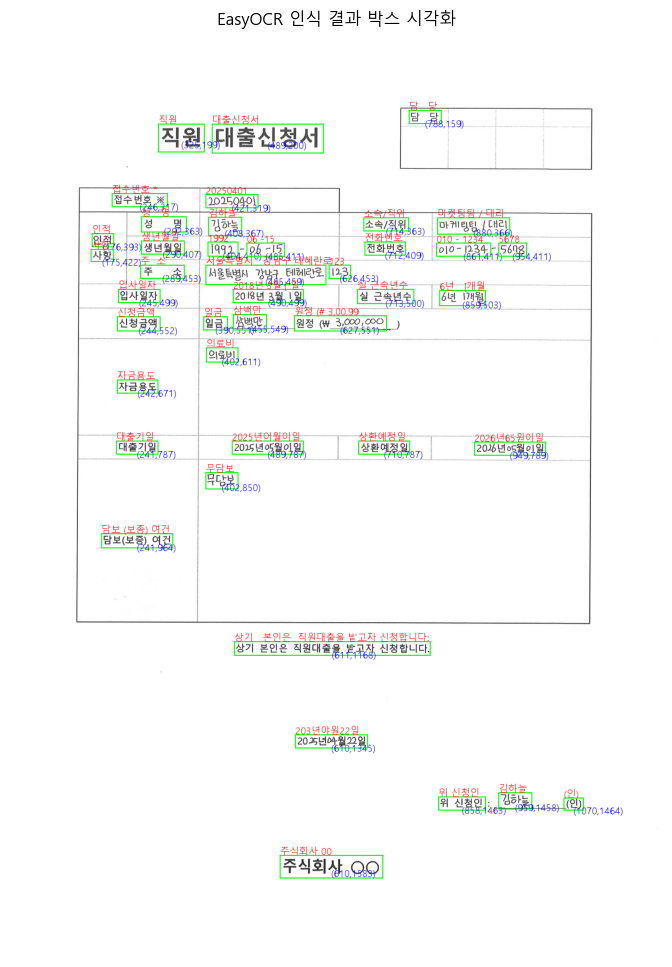

In [15]:
visualize_ocr_boxes(image_path)

## ✅ EASY OCR이 인식한 box 중 추출이 필요한 좌표를 가지고 와 필드 지정 -> 자동 추출

1) 추출하고 싶은 박스 영역을 직접 찍기
2) 좌표 영역을 json 파일로 저장 (다른 이미지 파일 추출시 사용)
3) 텍스트 추출


In [ ]:
pip install ipympl

In [25]:
pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.8 MB 6.1 MB/s eta 0:00:02
   --------- ------------------------------ 2.4/9.8 MB 6.0 MB/s eta 0:00:02
   -------------- ------------------------- 3.7/9.8 MB 6.0 MB/s eta 0:00:02
   -------------------- ------------------- 5.0/9.8 MB 6.0 MB/s eta 0:00:01
   ------------------------- -------------- 6.3/9.8 MB 6.0 MB/s eta 0:00:01
   ------------------------------ --------- 7.6/9.8 MB 6.1 MB/s eta 0:00:01
   ------------------------------------ --- 8.9/9.8 MB 6.1


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import streamlit as st
from PIL import Image
import json

st.set_page_config(page_title="OCR 템플릿 생성기", layout="centered")
st.title("🖱️ OCR 필드 템플릿 생성기")

# 이미지 업로드
uploaded_image = st.file_uploader("📤 이미지 업로드 (jpg, png)", type=["jpg", "jpeg", "png"])

if uploaded_image:
    image = Image.open(uploaded_image).convert("RGB")
    st.image(image, caption="📄 문서 미리보기", use_column_width=True)

    st.markdown("---")
    st.subheader("📌 필드명과 좌표(x, y)를 입력해 주세요")

    # 좌표 입력 테이블
    coords = st.experimental_data_editor(
        [{"필드명": "", "x": 0, "y": 0}],
        num_rows="dynamic",
        use_container_width=True
    )

    if st.button("💾 JSON 템플릿 저장하기"):
        template = {
            row["필드명"]: {"x": int(row["x"]), "y": int(row["y"])}
            for row in coords if row["필드명"] and row["x"] and row["y"]
        }

        json_data = json.dumps(template, ensure_ascii=False, indent=2)

        st.success("✅ 템플릿이 준비되었습니다! 아래 버튼으로 다운로드하세요.")
        st.download_button(
            label="⬇️ 템플릿 다운로드 (field_template.json)",
            data=json_data,
            file_name="field_template.json",
            mime="application/json"
        )

2025-04-25 17:05:33.888 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 17:05:33.889 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 17:05:33.941 
  command:

    streamlit run C:\Users\user\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-04-25 17:05:33.942 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 17:05:33.943 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 17:05:33.943 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 17:05:33.943 Thread 'MainThread': missing ScriptRunContext! This warning can be

In [27]:
streamlit run ocr_template_ui.py

SyntaxError: invalid syntax (3665884740.py, line 1)

※ 참고 <br/>

https://github.com/JaidedAI/EasyOCR?tab=readme-ov-file <br/>
https://yunwoong.tistory.com/76#google_vignette
